# Credit Card Fraud Detection using Anomaly Detection

Name: Soh Hong Yu<br/><br/>
Admin Number: P2100775<br/><br/>
Class: DAAA/FT/2A/01<br/><br/>
Module Code: ST1511 AI and Machine Learning<br/>

<hr>


# Initialising Libraries


In [1]:
import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


# Initialising of Dataset


In [2]:
dfRaw = pd.read_csv("./creditcard.csv")
print(dfRaw.shape)
print(dfRaw.columns)


(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100 * 492 / 284807, 3), "%")
data.head()


data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.173 %


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis


Mean 88.29102242225574 122.21132113821133
Median 22.0 9.25


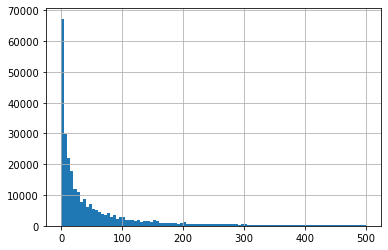

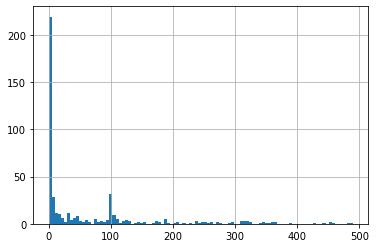

<Figure size 432x288 with 0 Axes>

In [4]:
normal_data["Amount"].loc[normal_data["Amount"] < 500].hist(bins=100)
plt.figure()
fraud_data["Amount"].loc[fraud_data["Amount"] < 500].hist(bins=100)
plt.figure()
print("Mean", normal_data["Amount"].mean(), fraud_data["Amount"].mean())
print("Median", normal_data["Amount"].median(), fraud_data["Amount"].median())


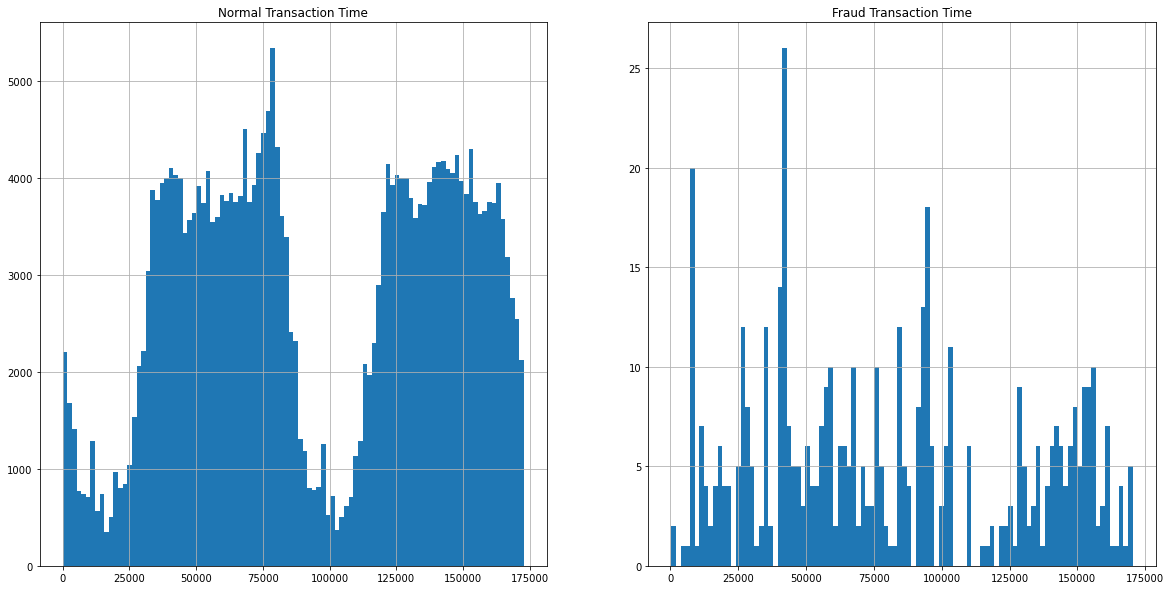

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
normal_data["Time"].hist(bins=100, ax=ax1)
ax1.set_title("Normal Transaction Time")
fraud_data["Time"].hist(bins=100, ax=ax2)
ax2.set_title("Fraud Transaction Time")
plt.show()


# Standardisation


In [6]:
#  SCALER / Normalization

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:]
pca_columns = list(data)[:-1]  # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data["Class"].values.reshape(-1, 1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns=XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100 * 492 / 284807, 4), "%")



data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.1727 %


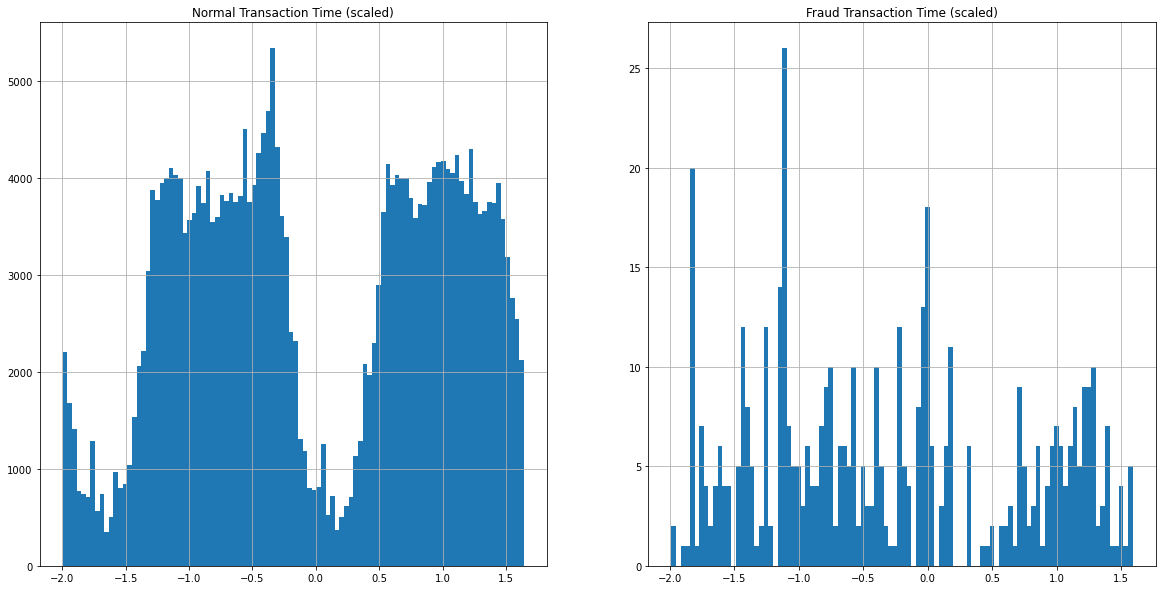

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
normal_data["Time"].hist(bins=100, ax=ax1)
ax1.set_title("Normal Transaction Time (scaled)")
fraud_data["Time"].hist(bins=100, ax=ax2)
ax2.set_title("Fraud Transaction Time (scaled)")
plt.show()


# Splitting data


In [8]:
normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
# print("X_valid ", X_valid.shape)
# print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]
PercFraud

print("X_inliers ", X_inliers.shape)
print("X_outliers ", X_outliers.shape)
print("X ", X.shape)
print("n_outliers ", n_outliers)
print("percent fraud in test: ", PercFraud)



normal_pca_data  (284315, 30)
fraud_pca_data (492, 30)
Fraud data only in Test with NONE in the training
X_train  (209315, 30)
X_test  (75492, 30)
y_test  (75492,)
X_inliers  (75000, 30)
X_outliers  (492, 30)
X  (75492, 30)
n_outliers  492
percent fraud in test:  0.0065172468605945


# Isolation Forest


In [9]:
from sklearn.ensemble import IsolationForest
isofo = IsolationForest(
    n_estimators=1050,
    max_features=1.0,
    max_samples=1.0,
    bootstrap=False,
    random_state=22,
    contamination=PercFraud,
)

y_pred = isofo.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
n_errors


530


In [10]:
y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

# F1 Score
# print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision, recall, fbeta_score, support = precision_recall_fscore_support(
    y_test, y_predLOF, average="binary"
)
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))


precision  0.4614
recall  0.4614
F1 score on Test 0.4614


In [11]:
# Optimize Num Estimators hyper paramter for best F1

minRE = 900
maxRE = 1150

EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 50):
    isofo = IsolationForest(
        n_estimators=TryRE,
        max_features=1.0,
        max_samples=1.0,
        bootstrap=False,
        random_state=22,
        contamination=PercFraud,
    )

    y_pred = isofo.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()

    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)

    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1

    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)

    precision, recall, fbeta_score, support = precision_recall_fscore_support(
        y_test, y_predLOF, average="binary"
    )

    print("F1 score on test", round(fbeta_score, 4), " with num_estimators ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score, 4)])

EpsF1df = pd.DataFrame(EpsF1, columns=["NumEstim", "F1"])
EpsF1df.head()


F1 score on test 0.4593  with num_estimators  900
F1 score on test 0.4573  with num_estimators  950
F1 score on test 0.4573  with num_estimators  1000
F1 score on test 0.4614  with num_estimators  1050
F1 score on test 0.4614  with num_estimators  1100


,NumEstim,F1
0,900,0.4593
1,950,0.4573
2,1000,0.4573
3,1050,0.4614
4,1100,0.4614


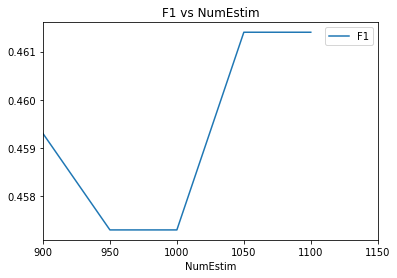

In [12]:
EpsF1df.plot.line("NumEstim", "F1")
plt.xlim(minRE, maxRE)
plt.title("F1 vs NumEstim")
plt.show()


# Local Outlier Factor


In [13]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=900, contamination=PercFraud)

y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
n_errors


420

In [14]:
y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

# F1 Score
# print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision, recall, fbeta_score, support = precision_recall_fscore_support(
    y_test, y_predLOF, average="binary"
)
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))


precision  0.5732
recall  0.5732
F1 score on Test 0.5732


# Robust Covariance


In [15]:
from sklearn.covariance import EllipticEnvelope
cov = EllipticEnvelope(support_fraction=0.994, contamination=PercFraud)

y_pred = cov.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
n_errors


196

In [16]:
y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

# F1 Score
# print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision, recall, fbeta_score, support = precision_recall_fscore_support(
    y_test, y_predLOF, average="binary"
)
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))


precision  0.8008
recall  0.8008
F1 score on Test 0.8008


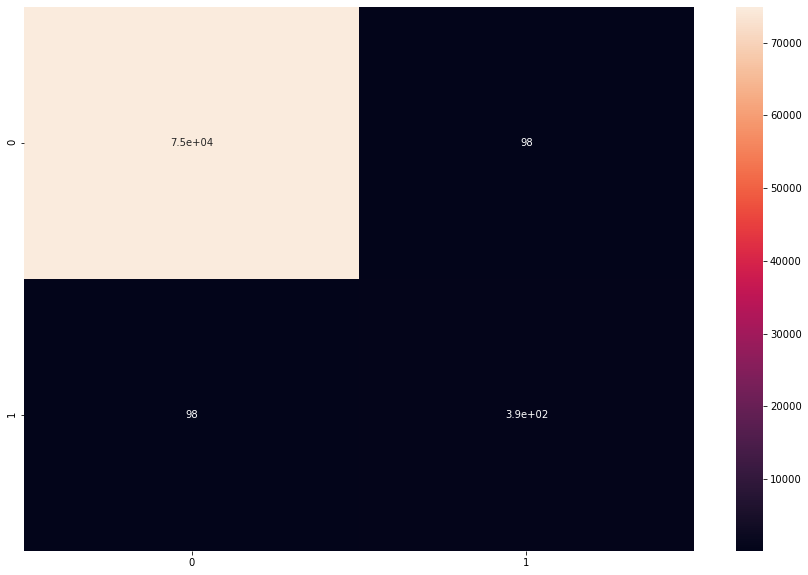

__________________________________________________
TP  394
FP  98
TN  74902
FN  98


In [17]:
CM = confusion_matrix(y_test, y_predLOF)
tn, fp, fn, tp = confusion_matrix(y_test, y_predLOF).ravel()
plt.figure(figsize=(15, 10))
sns.heatmap(CM, annot=True)
plt.show()
print("_" * 50)
print("TP ", tp)
print("FP ", fp)
print("TN ", tn)
print("FN ", fn)


In [18]:
# Optimize support_fraction hyper paramter for best F1

minRE = 0.95
maxRE = 0.99

EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 0.01):
    cov = EllipticEnvelope(support_fraction=TryRE, contamination=PercFraud)
    y_pred = cov.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()

    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)

    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1

    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)

    precision, recall, fbeta_score, support = precision_recall_fscore_support(
        y_test, y_predLOF, average="binary"
    )

    print("F1 score on test", round(fbeta_score, 4), " with support_fraction ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score, 4)])

EpsF1df = pd.DataFrame(EpsF1, columns=["SupFrac", "F1"])
EpsF1df.head()


F1 score on test 0.8028  with support_fraction  0.95
F1 score on test 0.8028  with support_fraction  0.96
F1 score on test 0.8028  with support_fraction  0.97
F1 score on test 0.8028  with support_fraction  0.98
F1 score on test 0.8008  with support_fraction  0.99


,SupFrac,F1
0,0.95,0.8028
1,0.96,0.8028
2,0.97,0.8028
3,0.98,0.8028
4,0.99,0.8008


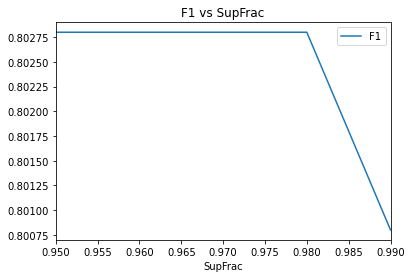

In [19]:
EpsF1df.plot.line("SupFrac", "F1")
plt.xlim(minRE, maxRE)
plt.title("F1 vs SupFrac")
plt.show()


In [23]:
data = [[0.4614,0.4614,0.4614],[0.5732,0.5732,0.5732],[0.8008,0.8008,0.8008]]
data = pd.DataFrame(data).T.rename({0:"precision",1:'recall',2:'f1'}).rename({0:"Isolation Forest",1:'Local Outlier Factor',2:'Robust Covariance'},axis=1)
data

,Isolation Forest,Local Outlier Factor,Robust Covariance
precision,0.4614,0.5732,0.8008
recall,0.4614,0.5732,0.8008
f1,0.4614,0.5732,0.8008
